In [1]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm
import seaborn as sns
import xarray as xr

import arviz as az

import utils as utils  



from scipy import stats as stats

from matplotlib import pyplot as plt

#### Trolley problem

Researchers have tried to catalog trolly problem scenarios along multiple feature dimensions, three common features are:

- **Action**: taking an action is less morally permissible than not taking an action (you intervening on a scene is condidered worse than letting the scene play out)
- **Intention**: does the actor's direct goal affect the scenario (e.g. intentially killing one person to save five)
- **Contact**: intentions are worse if the actor comes into direct contact with the object of the action (e.g. directly pushing a person off a bridge to save others)

- 9330 total responses
- 331 individuals
- 30 different trolley problem scenarios
- vary along action, intention, contact dimensions
- responses are ordered integer values ranging from 1 to 7 indicating the "appropriateness" of action
  - not counts
  - ordered but not continous ordered
  - bounded

In [4]:
TROLLEY = utils.load_data("Trolley")
N_TROLLEY_RESPONSES = len(TROLLEY)
N_RESPONSE_CATEGORIES = TROLLEY.response.max()
TROLLEY.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


Ordered Categories:
* Distance from say 4 to 5 isnt necessarily the same as say 6-7. Therefore this is not an int value but an ordered category
* Anchor points are commmon 
    * Here it's 4, as the kind of 'middle' 'meh' value
    * Important to have a distribution that can recover this anchor points

Ordered=Cumulative

Of course now having probabilities of say X<=5

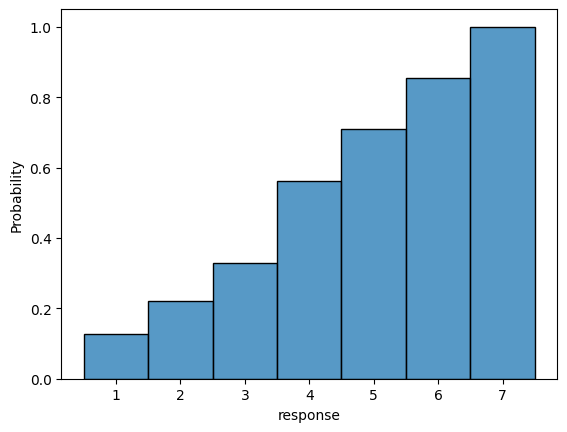

In [5]:
sns.histplot(TROLLEY["response"], cumulative=True, bins = [1,2,3,4,5,6,7,8], stat="probability", discrete=True);plt.show()

#### Cumulative log odds

In [6]:
TROLLEY_cum_prob = pd.DataFrame(TROLLEY['response'].value_counts(normalize=True).sort_index().cumsum())
TROLLEY_cum_prob["log_odds"] = np.log(TROLLEY_cum_prob/(1-TROLLEY_cum_prob))

c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


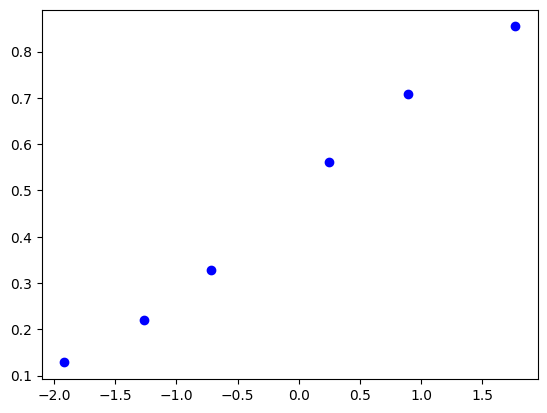

In [7]:
plt.scatter(TROLLEY_cum_prob["log_odds"], TROLLEY_cum_prob["proportion"], marker="o", linestyle="-", color="blue")

These points are 'cutpoints'. We want to estimate these as a way of estimating the shape of the dist. any categorical dist we like
* There are 1 less than the number of outcomes cutpoints

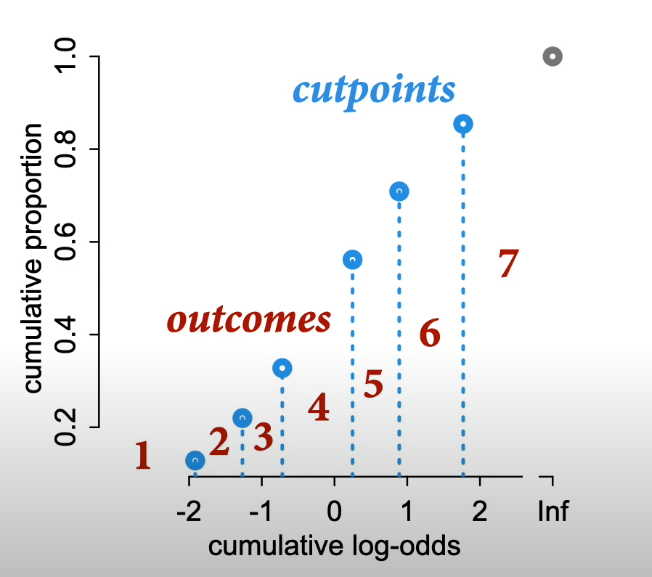

OK, Now to predict the data, we have to do this in reverse again
* We have to do this, if we dont go to cumprob we cant enforce ordering, so now we done that, we estimtated the cutpoints and now its time to go back and predict our categories (1,2,3 etc.)

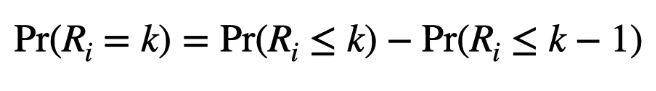
* We want the prob of some response R equal to k, where
    * k is any number from 1 to 7
    * given to us by a difference between the probabilty of R being less or equal to k and the probabilty of rating R being less or equal k-1

Say

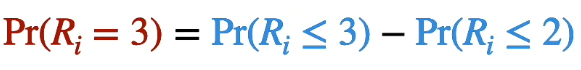

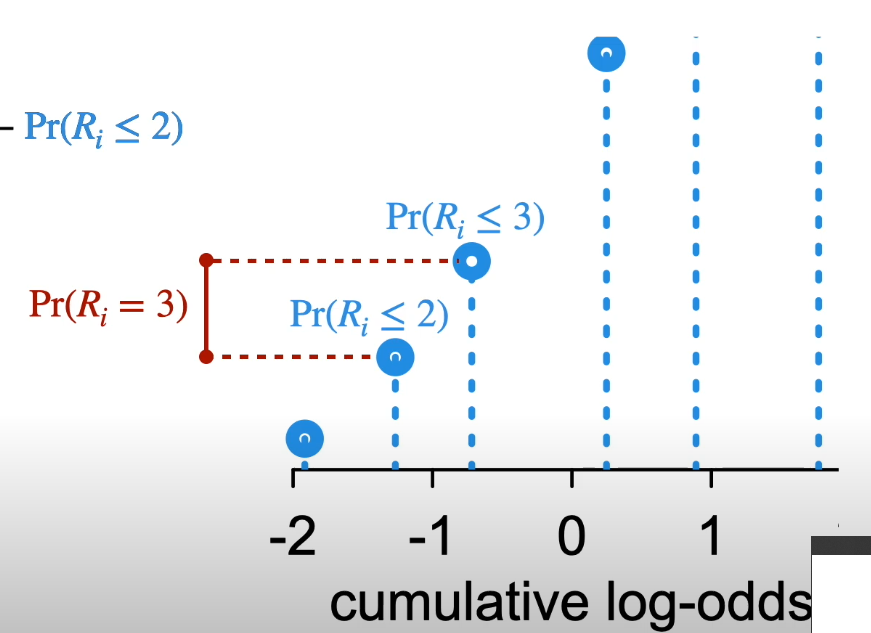

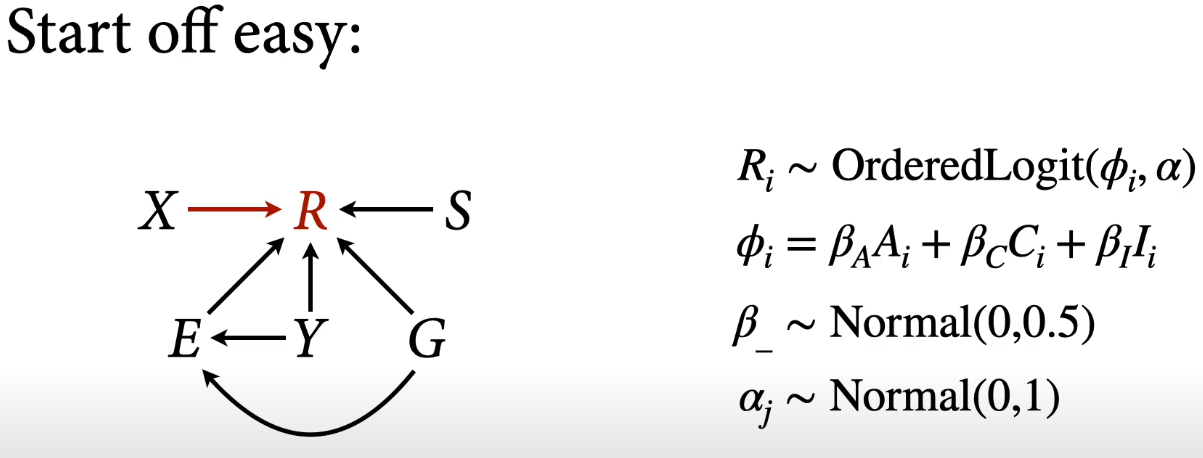

<Axes: >

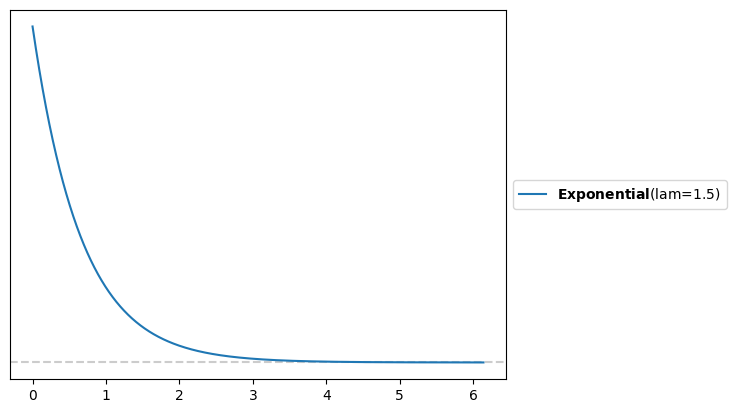

In [8]:
import preliz as pz
pz.Exponential(1.5).plot_pdf()

In [10]:
response_id, response = pd.factorize(TROLLEY['response'], sort=True)
n_response_categories = len(response)
cutpoints = np.arange(1, n_response_categories).astype(int)

coords = {"cutpoints": cutpoints}

In [59]:
response_id, response = pd.factorize(TROLLEY['response'], sort=True)
n_response_categories = len(response)
cutpoints = np.arange(1, n_response_categories).astype(int)

coords = {"cutpoints": cutpoints}

with pm.Model(coords=coords) as simple_ordered_categories_model:
    # MutableData for posetior predictions
    action = pm.MutableData('action', TROLLEY.action.astype(float))
    intent = pm.MutableData('intent', TROLLEY.intention.astype(float))
    contact = pm.MutableData('contact', TROLLEY.contact.astype(float))
    
    # Priors
    beta_action = pm.Normal("beta_action", 0, 0.5)
    beta_intent = pm.Normal("beta_intent", 0, 0.5)
    beta_contact = pm.Normal("beta_contact", 0, 0.5)
    
    cutpoints = pm.Normal(
        "alpha",
        mu=0, sigma=1,
        transform=pm.distributions.transforms.univariate_ordered,
        shape=n_response_categories-1,
        testval=np.arange(n_response_categories - 1) - 2.5,  # use ordering (with coarse log-odds centering) for init
        dims='cutpoints'
    )
    #likelihood
    phi = beta_action * action + beta_intent * intent + beta_contact * contact
    pm.OrderedLogistic(
        'response',
        cutpoints=cutpoints,
        eta=phi,
        
        observed=response_id
    )
    
    simple_ordered_categories_inference = pm.sample()
    

C:\Users\Kuba\AppData\Local\Temp\ipykernel_13836\44439895.py:18: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_action, beta_intent, beta_contact, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 228 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [61]:
az.summary(
    simple_ordered_categories_inference,
    var_names=['beta_contact', 'beta_intent','beta_action', 'alpha']
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_contact,-0.945,0.050,-1.037,-0.853,0.001,0.001,1596.0,1543.0,1.0
beta_intent,-0.712,0.037,-0.784,-0.648,0.001,0.001,1615.0,1501.0,1.0
beta_action,-0.696,0.039,-0.769,-0.627,0.001,0.001,1390.0,1266.0,1.0
alpha[1],-2.826,0.047,-2.914,-2.737,0.001,0.001,1091.0,1482.0,1.0
alpha[2],-2.142,0.042,-2.221,-2.063,0.001,0.001,1176.0,1506.0,1.0
alpha[3],-1.558,0.040,-1.634,-1.490,0.001,0.001,1169.0,1251.0,1.0
alpha[4],-0.538,0.037,-0.610,-0.473,0.001,0.001,1327.0,1439.0,1.0
alpha[5],0.131,0.036,0.060,0.197,0.001,0.001,1394.0,1470.0,1.0
alpha[6],1.039,0.039,0.966,1.114,0.001,0.001,1723.0,1756.0,1.0


Then we did posterior predictive distributions

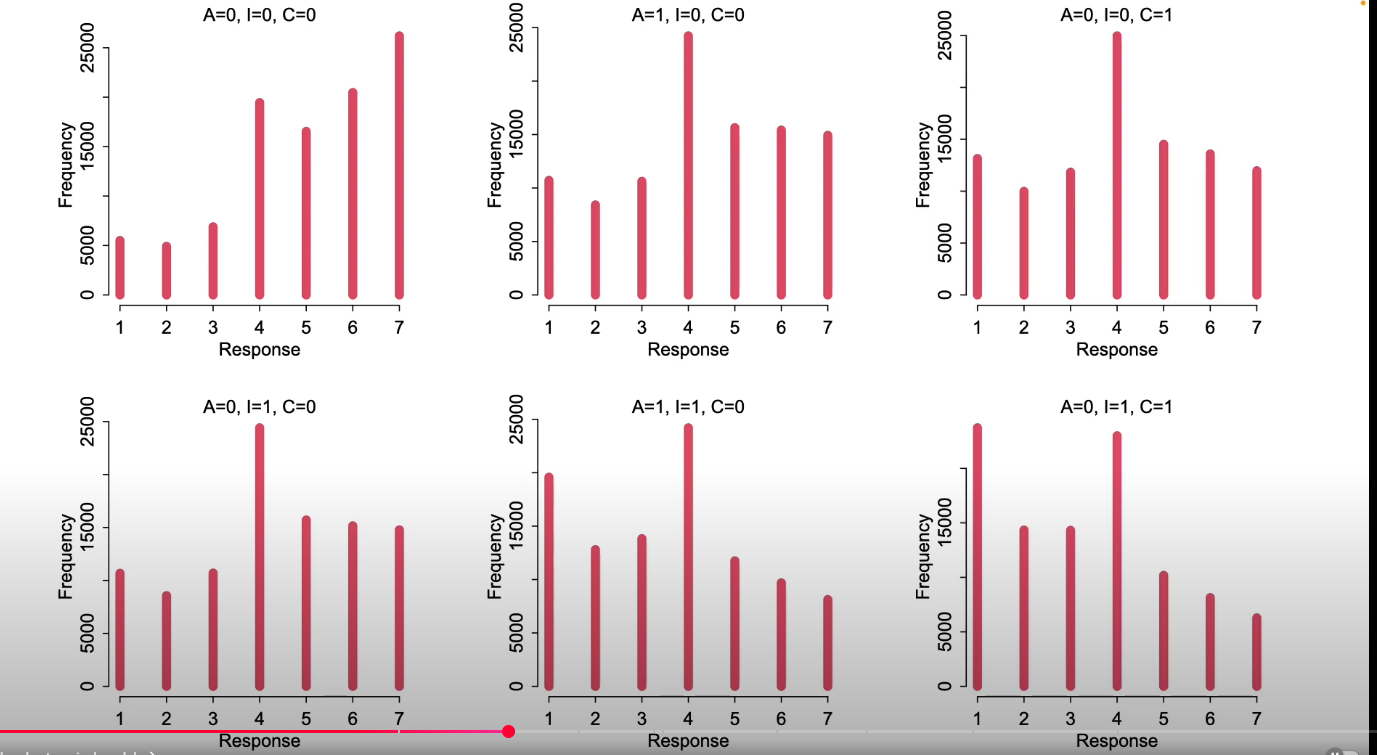

#### Competing Causes

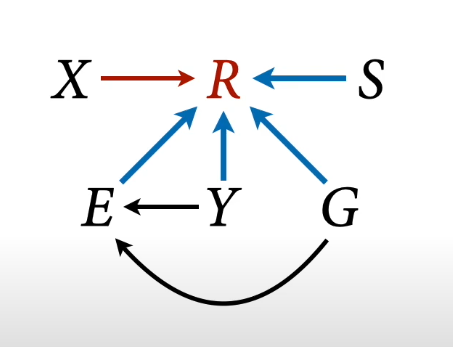

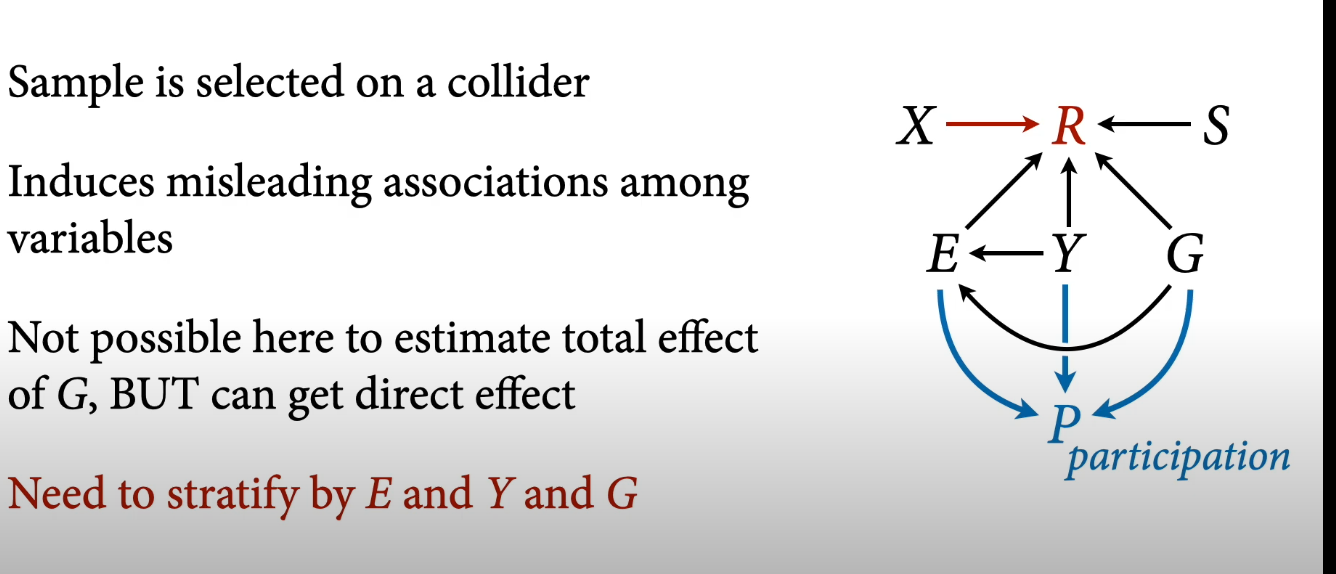

#### Ordered predictors
* Say education is also an ordered category here
* Need a parameter for each level
* How do we enforce ordering so that each lvl hals larger or smaller effect than previous?

For each level of education:
1. (Elementary School) $\rightarrow \phi_i = 0$
2. (Middle School) $\rightarrow \phi_i = \delta_1$
3. (Some High School) $\rightarrow \phi_i = \delta_1 + \delta_2$
4. (High School Graduate) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3$
5. (Some College) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4$
6. (College Graduate) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5$
7. (Master's Degreee) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5 + \delta_6$
8. (Graduate Degreee) $\rightarrow \phi_i = \delta_1 + \delta_2 + \delta_3 + \delta_4 + \delta_5 + \delta_6+ \delta_7 = \beta_E$

where $\beta_E$ is the maximum effect of education. We thus break down the maximum effect into a convex combination of education terms.

$$
\begin{align*}
\delta_0 &= 0 \\
\phi_i &= \sum_{j=0}^{E_i-1} \delta_j = 1
\end{align*}
$$]

* So when we sum up the params of all levels of education they will sum to 1

This "procedure" enforces ordering and makes the effect monotonic, that is either more education increases or decreases the response

#### How do we set priors for the ordered monotonic predictor parameters
* These delta params form a simplex: VECTOR THAT SUMS TO 1

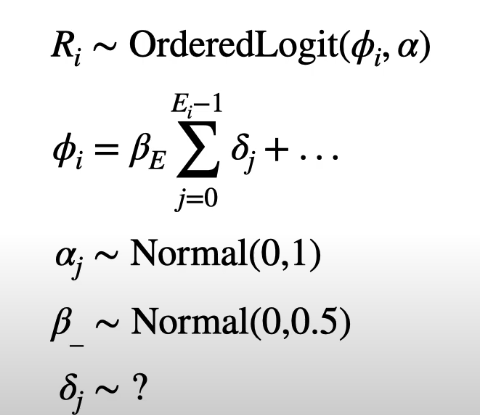


For gamma we will use a Dirichlet(a) distribution, which is a distribution for distributions
* a parameter is a vector of positive nums
* So this a parameter, the elemnts of vectors, when we set them to say "2s" this just says there is no prior expectation which one is bigger than the other,  it doesnt say that they are all the same.
    * Increasing the elements of the a vector to say "10s" reduces the variance, that is we still dont know which is bigger, but we are more sure that they are close together

    * When we have say 1,2,3,4,5,6,7 in a vector we assume prior knowledge of some order, one being bigger than the other

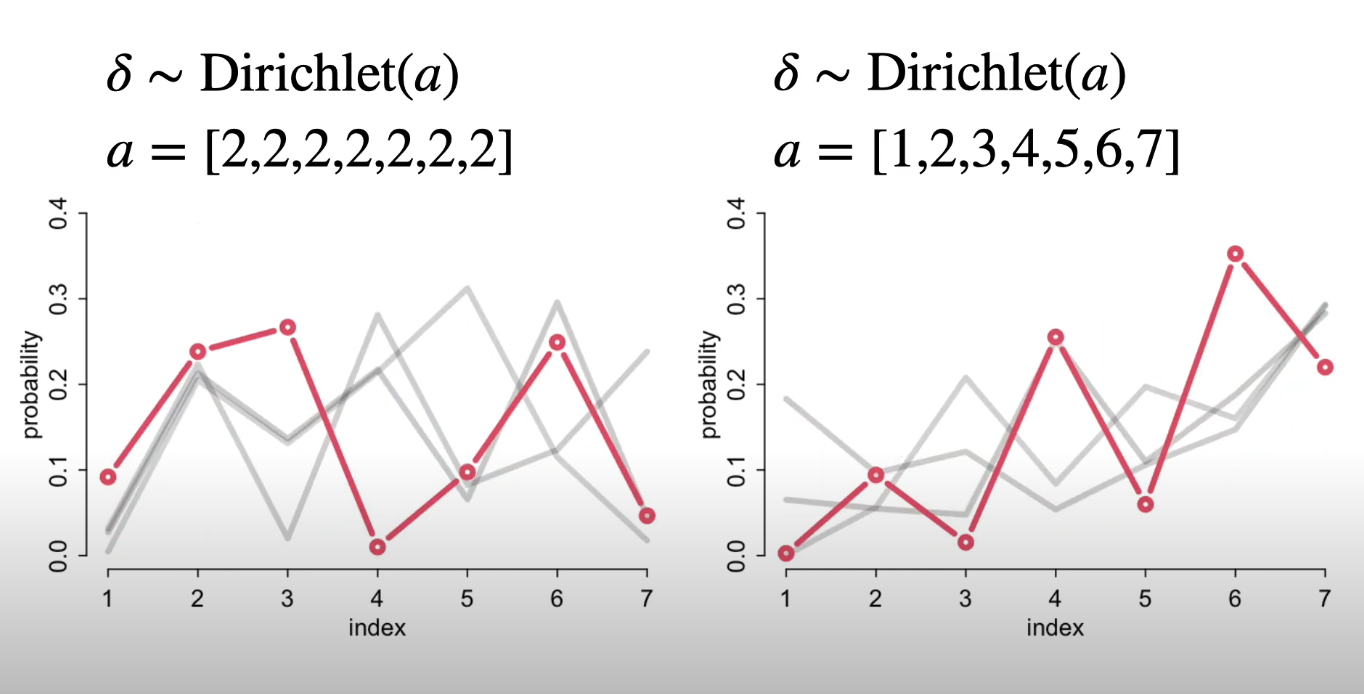

CODE PYMC IS IN official notebook

KeyError: "Bachelor's Degree"